<img src="a20_a21_a22_jaccard.svg" style="text-align:center;width:50%;display:inline;"><img src="a20_a21_a22_partial.svg" style="text-align:center;width:50%;display:inline;">

# Sentence architecture

### Sentence architecture properties:
* __left branching__ — A sentence that opens with modifying structures and so postpones its subject is said to branch to the left. Example: 'In the distance, above the noise of the crowd, I thought I could hear the sound of guns.'
* __middle branching__ — A sentence that inserts material between the subject and verb. Example: 'Even the children, brought there with the rest of the family, stared intently.'
* __right branching__ — A sentence that is complete gramatically but continues with modifying clauses or phrases. Example: 'There were hundreds of small groups, each concentrated around someone who was haranguing the others, using the familiar, heavy public gestures of the Chinese.'
* __Periodic sentences__ — A sentence that completes itself gramatically and/or delivers its meaning, often dramatically, at the end. Often, a 'pause' is inserted before the final predication, such as a dash
* __loose sentences__ — A sentence that trails off in accumulated detail with no concluding point.


In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import utils
import importlib
import ast
from tqdm import tqdm
import re

In [24]:
importlib.reload(utils)
connection = utils.connectDB()

In [3]:
FEATURE = "Sentence_architecture"

In [4]:
# IMPORTANT: GPT data was corrected. Read the corrected GPT sheet NOT the database
gpt_df = pd.read_csv("corrected_GPT_min.csv")

In [5]:
# When this data is read in the majority_prop Type is incomaptible with the script downstream, so we just recreate this column each time
gpt_df['majority_prop'] = [list(utils.find_majority(ast.literal_eval(l))[0]) for l in gpt_df['all_properties']]

In [6]:
gpt_df.head()

,sentence_id,all_properties,feature_id,majority_prop
0,265,"[{'simple'}, {'simple'}, {'simple'}, {'simple'...",Aspect,[simple]
1,265,"[{'indicative'}, {'indicative'}, {'indicative'}]",Mood,[indicative]
2,265,[],Verb_choices,[]
3,265,"[{'subordinate'}, {'subordinate', 'adjective'}...",Modifying_clauses,"[adjective, subordinate]"
4,265,"[{'multiplying and embedding modifiers', 'sing...",Modifying_phrases,"[single word modifiers, prepositional phrases,..."


In [7]:
query = 'select * from annotations where annotator_id in (20,21,22) and completed=1;'
annotations = pd.read_sql(query, connection)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


### Format the human annotations like GPT for making comaprisons
This will roll the annotations up to the sentence level

In [8]:
a_20 = utils.annotationsToGPTFormat(20,annotations)
a_21 = utils.annotationsToGPTFormat(21,annotations)
a_22 = utils.annotationsToGPTFormat(22,annotations)

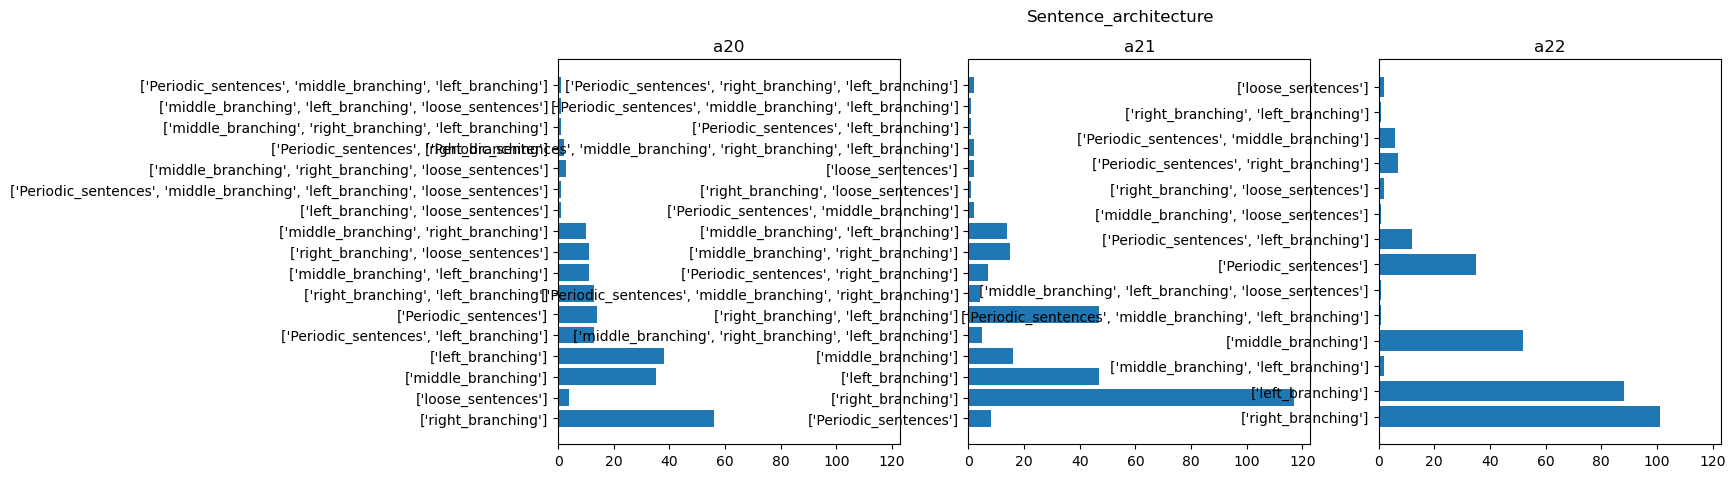

In [9]:
utils.plotPropertyDistributions(FEATURE,a_20,a_21,a_22)

In [10]:
features_gpt = list(gpt_df.groupby('feature_id').agg(list).reset_index()['feature_id'])
idx_gpt = features_gpt.index(FEATURE)
gpt_df_properties = gpt_df.groupby('feature_id').agg(list).reset_index().loc[idx_gpt][['all_properties','sentence_id']]
cGPT = Counter([str(utils.find_majority(ast.literal_eval(l))[0]) for l in gpt_df_properties['all_properties']])

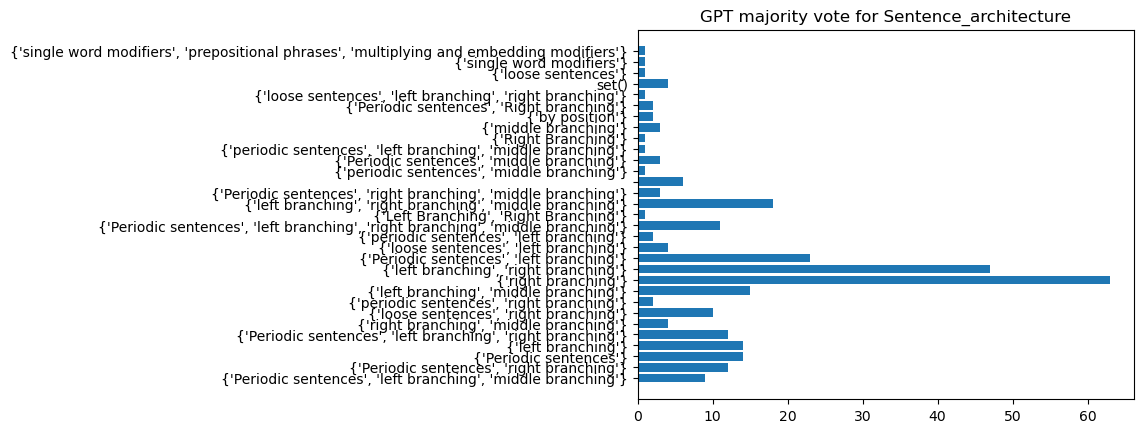

In [11]:
plt.barh(list(cGPT.keys()),list(cGPT.values()))
plt.title("GPT majority vote for "+FEATURE)
plt.show()

### Find all the sentences where there is agreement on the majority property



In [12]:
majority_property = 'right_branching'

In [13]:
a_20_sent = set(a_20[a_20['properties'].apply(lambda x: x == [majority_property])]['sentence_id'])
a_21_sent = set(a_21[a_21['properties'].apply(lambda x: x == [majority_property])]['sentence_id'])
a_22_sent = set(a_22[a_22['properties'].apply(lambda x: x == [majority_property])]['sentence_id'])
gpt_df_sent = set(gpt_df[gpt_df['majority_prop'].apply(lambda x: x == [majority_property])]['sentence_id'])

In [14]:
all_agreed_sentences = a_20_sent.intersection(a_21_sent,a_22_sent,gpt_df_sent)

In [15]:
len(all_agreed_sentences)

0

### Find all the sentences (and the respective annotations) that are not in the agreed sentences list

### Find all sentences

In [16]:
query = 'SELECT id, technique, text FROM ebdb.sample_sentences;'
non_agreed_sentences = pd.read_sql(query, connection)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [17]:
non_agreed_sentences['feature_id'] = FEATURE
non_agreed_sentences['props_a20'] = ''
non_agreed_sentences['props_a21'] = ''
non_agreed_sentences['props_a22'] = ''
non_agreed_sentences['props_gpt'] = ''

In [18]:
non_agreed_sentences = non_agreed_sentences[['id', 'technique', 'text', 'feature_id', 'props_a20', 'props_a21', 'props_a22', 'props_gpt']]
non_agreed_sentences = non_agreed_sentences.rename(columns={'id':'sentence_id'})

In [19]:
print(len(non_agreed_sentences))
non_agreed_sentences.head()

357


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Sentence_architecture,,,,
1,11,[0 8],We are simply asked to take the pope’s word fo...,Sentence_architecture,,,,
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Sentence_architecture,,,,
3,16,[0],"According to Breitbart, “Sellner, who describe...",Sentence_architecture,,,,
4,23,[0],“This is a clear violation of the Senate Ethic...,Sentence_architecture,,,,


In [20]:
utils.fillInAnnotations(non_agreed_sentences,a_20,a_21,a_22,gpt_df,FEATURE)

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Sentence_architecture,[right_branching],[Periodic_sentences],[right_branching],
1,11,[0 8],We are simply asked to take the pope’s word fo...,Sentence_architecture,[right_branching],[right_branching],[right_branching],
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Sentence_architecture,[loose_sentences],[left_branching],[left_branching],
3,16,[0],"According to Breitbart, “Sellner, who describe...",Sentence_architecture,[middle_branching],[left_branching],"[middle_branching, left_branching]",
4,23,[0],“This is a clear violation of the Senate Ethic...,Sentence_architecture,[right_branching],[right_branching],"[middle_branching, left_branching]",
...,...,...,...,...,...,...,...,...
352,14484,[],"They noted Haig's LinkedIn page, which says he...",Sentence_architecture,,[right_branching],[right_branching],"[left branching, right branching]"
353,14506,[],"When asked about the threats, Haig said, “I’ve...",Sentence_architecture,[left_branching],"[right_branching, left_branching]","[Periodic_sentences, left_branching]","[Periodic sentences, left branching]"
354,14878,[],"In 1953, the CIA was in the process of develop...",Sentence_architecture,[left_branching],"[right_branching, left_branching]",[left_branching],"[left branching, right branching]"
355,15168,[],"“If code is speech, the constitutional contrad...",Sentence_architecture,,"[right_branching, left_branching]",[left_branching],"[left branching, right branching]"


In [21]:
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

### Find rows with missing GPT responses

In [22]:
to_reprompt = non_agreed_sentences[non_agreed_sentences['props_gpt']=='']

In [23]:
print(len(to_reprompt))
to_reprompt.head()

66


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Sentence_architecture,[right_branching],[Periodic_sentences],[right_branching],
1,11,[0 8],We are simply asked to take the pope’s word fo...,Sentence_architecture,[right_branching],[right_branching],[right_branching],
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Sentence_architecture,[loose_sentences],[left_branching],[left_branching],
3,16,[0],"According to Breitbart, “Sellner, who describe...",Sentence_architecture,[middle_branching],[left_branching],"[middle_branching, left_branching]",
4,23,[0],“This is a clear violation of the Senate Ethic...,Sentence_architecture,[right_branching],[right_branching],"[middle_branching, left_branching]",


### Reprompt GPT 3 times and merge with non_agreed_sentences

In [24]:
# model = "gpt-3.5-turbo-0301"
# model = "gpt-3.5-turbo-0613"
# model = "gpt-3.5-turbo-1106"
# model = "gpt-4"

In [25]:
import GPT
importlib.reload(GPT)

<module 'GPT' from '/Users/kylehamilton/MyDocuments/ML-Labs/annotation-app/rhetoric-annotation/results/GPT.py'>

In [26]:
def parseRes(x):
    try:
        result = utils.parseGPTresponse(x)[1][0]
    except:
        result = []
    return result

for i in range(1,4):
    responses = []
    gpt = GPT.GPT("gpt-3.5-turbo-1106")

    for row in tqdm(to_reprompt.iterrows()):
        sentence = row[1]['text']
        feature = row[1]['feature_id']
        sid = row[1]['sentence_id']
        promt, response = gpt.get_gpt_response(sentence,feature,sid)
        responses.append([sid, response])

    df = pd.DataFrame(responses, columns=['sentence_id','res'+str(i)])
    df['gpt_props'+str(i)] = df['res'+str(i)].apply(parseRes)
    non_agreed_sentences = non_agreed_sentences.merge(df, how='outer',on='sentence_id')
    non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

    print(f"There were {len(gpt.errors)} errors in round {i}.")

66it [01:40,  1.52s/it]


There were 0 errors in round 1.


66it [01:42,  1.55s/it]


There were 0 errors in round 2.


66it [06:30,  5.92s/it]

There were 1 errors in round 3.


In [27]:
# Sanity check
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
print(len(non_agreed_sentences))
non_agreed_sentences.head()

357


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt,res1,gpt_props1,res2,gpt_props2,res3,gpt_props3
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Sentence_architecture,['right_branching'],['Periodic_sentences'],['right_branching'],NaN,"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"{\n ""Properties"": [""right branching"", ""period...","['right_branching',_'periodic_sentences']"
1,11,[0 8],We are simply asked to take the pope’s word fo...,Sentence_architecture,['right_branching'],['right_branching'],['right_branching'],NaN,"``` \n ""Properties"": [""periodic sentenc...",[],"``` \n{\n ""Properties"": [\n ""right branchi...",[],"{\n ""Properties"": [""right branching"", ""loose ...","['right_branching',_'loose_sentences']"
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Sentence_architecture,['loose_sentences'],['left_branching'],['left_branching'],NaN,"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching']
3,16,[0],"According to Breitbart, “Sellner, who describe...",Sentence_architecture,['middle_branching'],['left_branching'],"['middle_branching', 'left_branching']",NaN,"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"```json\n{\n ""Properties"": [""right branchin...",[],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching']
4,23,[0],“This is a clear violation of the Senate Ethic...,Sentence_architecture,['right_branching'],['right_branching'],"['middle_branching', 'left_branching']",NaN,"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"```json\n {\n ""Properties"": ...",[],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching']


In [28]:
# get the majority vote from the annotators (props_a20, props_a21, props_a22)

# What to do when there is no majority? NA?


non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a20']+", "+\
                                           non_agreed_sentences['props_a21']+", "+\
                                           non_agreed_sentences['props_a22'] #.apply(utils.find_majority)

def convert(x):
    try: result = list(ast.literal_eval(x))
    except: result = [[]]
    return result

non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(convert)
non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(lambda l: utils.find_majority(l)[0])

In [29]:
# get the majority vote from the reprompt (gpt_props1, gpt_props2, gpt_props3)

non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['gpt_props1']+", "+\
                                           non_agreed_sentences['gpt_props2']+", "+\
                                           non_agreed_sentences['gpt_props3'] #.apply(utils.find_majority)

def convert(x):
    try: result = list(ast.literal_eval(x))
    except: result = [[]]
    return result

non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(convert)
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(lambda l: utils.find_majority(l)[0])

In [30]:
# Merge the previous gpt props with the newly reprompted ones into a single column
def convert(x):
    try: 
        result = list(ast.literal_eval(x))
        result = [r.replace(" ","_") for r in result]
    except: 
        result = []
    return result

non_agreed_sentences['props_gpt'] = non_agreed_sentences['props_gpt'].apply(convert)
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'] + non_agreed_sentences['props_gpt']
non_agreed_sentences = non_agreed_sentences.drop(['props_gpt'], axis=1)


### Calculate agreement between annotator majority and GPT majority

One issue is that when there is no majority the last item is selected

In [31]:
non_agreed_sentences['ann_gpt_agreemnt'] = non_agreed_sentences.apply(lambda x: utils.calcAgreement(x['props_a_majority'],x['props_gpt_majority']), axis=1)

In [32]:
# save the final version
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

In [33]:
# Sanity check
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
print(len(non_agreed_sentences))
non_agreed_sentences.head()

357


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res1,gpt_props1,res2,gpt_props2,res3,gpt_props3,props_a_majority,props_gpt_majority,ann_gpt_agreemnt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Sentence_architecture,['right_branching'],['Periodic_sentences'],['right_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"{\n ""Properties"": [""right branching"", ""period...","['right_branching',_'periodic_sentences']",['right_branching'],[],-1
1,11,[0 8],We are simply asked to take the pope’s word fo...,Sentence_architecture,['right_branching'],['right_branching'],['right_branching'],"``` \n ""Properties"": [""periodic sentenc...",[],"``` \n{\n ""Properties"": [\n ""right branchi...",[],"{\n ""Properties"": [""right branching"", ""loose ...","['right_branching',_'loose_sentences']",['right_branching'],[],-1
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Sentence_architecture,['loose_sentences'],['left_branching'],['left_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],['left_branching'],['right_branching'],-1
3,16,[0],"According to Breitbart, “Sellner, who describe...",Sentence_architecture,['middle_branching'],['left_branching'],"['middle_branching', 'left_branching']","{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"```json\n{\n ""Properties"": [""right branchin...",[],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],['middle_branching'],['right_branching'],-1
4,23,[0],“This is a clear violation of the Senate Ethic...,Sentence_architecture,['right_branching'],['right_branching'],"['middle_branching', 'left_branching']","{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"```json\n {\n ""Properties"": ...",[],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],['right_branching'],['right_branching'],1


# FIX ALL THE ERRORS
(Majorities are calculated at the list level, not the item level for both annotators and GPT)

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import utils
import importlib
import ast
from tqdm import tqdm
import re

In [2]:
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/annotation-app/rhetoric-annotation/results/utils.py'>

In [3]:
FEATURE = "Sentence_architecture"

In [4]:
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")

def parseRes(x):
    try:
        result = utils.parseGPTresponse(x)[1][0]
    except:
        result = []
    return result

for i in range(1,4):
    non_agreed_sentences['gpt_props'+str(i)] = non_agreed_sentences['res'+str(i)].apply(parseRes)

def listOfLists(*lists):
    new_list = []
    for l in lists:
        if len(l):
            new_list.append(l)
    return new_list

non_agreed_sentences['props_gpt_list'] = non_agreed_sentences.apply(lambda x: listOfLists(x['gpt_props1'],
                                                                                          x['gpt_props2'],
                                                                                          x['gpt_props3']), axis=1)
def find_majority(row):
    if len(row.props_gpt_list):
        return utils.find_majority(row.props_gpt_list)[0]
    else:
        return row.props_gpt_majority
    
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences.apply(lambda x: find_majority(x),axis=1)
non_agreed_sentences = non_agreed_sentences.drop(['props_gpt_list'], axis=1)

# # the old GPT majorities still have spaces. Remove spaces
def replaceSpaces(x):
    if type(x) == str:
        x = ast.literal_eval(x)
    x = [i.replace(" ","_") for i in x]
    return x

non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(replaceSpaces)
non_agreed_sentences['ann_gpt_agreemnt'] = non_agreed_sentences.apply(lambda x: utils.calcAgreement(x['props_a_majority'],x['props_gpt_majority']), axis=1)

non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")


In [5]:
non_agreed_sentences

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res1,gpt_props1,res2,gpt_props2,res3,gpt_props3,props_a_majority,props_gpt_majority,ann_gpt_agreemnt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Sentence_architecture,['right_branching'],['Periodic_sentences'],['right_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"{\n ""Properties"": [""right branching"", ""period...","['right_branching', 'periodic_sentences']",['right_branching'],['right_branching'],1
1,11,[0 8],We are simply asked to take the pope’s word fo...,Sentence_architecture,['right_branching'],['right_branching'],['right_branching'],"``` \n ""Properties"": [""periodic sentenc...",['periodic_sentences'],"``` \n{\n ""Properties"": [\n ""right branchi...",[],"{\n ""Properties"": [""right branching"", ""loose ...","['right_branching', 'loose_sentences']",['right_branching'],['periodic_sentences'],-1
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Sentence_architecture,['loose_sentences'],['left_branching'],['left_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],['left_branching'],['right_branching'],-1
3,16,[0],"According to Breitbart, “Sellner, who describe...",Sentence_architecture,['middle_branching'],['left_branching'],"['middle_branching', 'left_branching']","{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"```json\n{\n ""Properties"": [""right branchin...",['right_branching'],"{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],['middle_branching'],['right_branching'],-1
4,23,[0],“This is a clear violation of the Senate Ethic...,Sentence_architecture,['right_branching'],['right_branching'],"['middle_branching', 'left_branching']","{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],"```json\n {\n ""Properties"": ...","['right_branching', 'periodic_sentences']","{\n ""Properties"": [""right branching""],\n ""Ex...",['right_branching'],['right_branching'],['right_branching'],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,14484,[],"They noted Haig's LinkedIn page, which says he...",Sentence_architecture,NaN,['right_branching'],['right_branching'],NaN,[],NaN,[],NaN,[],[],"['left_branching', 'right_branching']",-1
353,14506,[],"When asked about the threats, Haig said, “I’ve...",Sentence_architecture,['left_branching'],"['right_branching', 'left_branching']","['Periodic_sentences', 'left_branching']",NaN,[],NaN,[],NaN,[],['left_branching'],"['Periodic_sentences', 'left_branching']",0
354,14878,[],"In 1953, the CIA was in the process of develop...",Sentence_architecture,['left_branching'],"['right_branching', 'left_branching']",['left_branching'],NaN,[],NaN,[],NaN,[],['left_branching'],"['left_branching', 'right_branching']",0
355,15168,[],"“If code is speech, the constitutional contrad...",Sentence_architecture,NaN,"['right_branching', 'left_branching']",['left_branching'],NaN,[],NaN,[],NaN,[],[],"['left_branching', 'right_branching']",-1
